In [317]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [318]:

def merge(nums):
    i, j = random.sample(range(len(nums)), 2) 
    a, b = nums[i], nums[j]  
    if i < j:                    
        del nums[j]
        del nums[i]
    else:
        del nums[i]
        del nums[j]

    nums.append(abs(a - b))
    return nums

In [319]:
def hat(max):
    nums = list(range(1,max+1))
    for i in range(max): #each parse will reduce the number of elements by 1 so we dont need more then this
        if len(nums) > 1:
            
            merge(nums)

        else: return nums[0]


In [320]:
def heathat(n, sims):

    m = n + 1
    values = np.arange(0, n + 1)

    freq = np.zeros((n, m), dtype=np.int32)  

    master = random.Random(None)
    sim_seeds = [master.randrange(0, 2**31 - 1) for _ in range(sims)]

    for s in range(sims):
        rng = random.Random(sim_seeds[s])

        bag = list(range(1, n + 1))
        counts = np.zeros(n + 1, dtype=np.int32)
        counts[1:] = 1

        # step 0
        freq[0] += (counts > 0).astype(np.int32)

        for t in range(1, n):
            a = bag.pop(rng.randrange(len(bag)))
            b = bag.pop(rng.randrange(len(bag)))
            d = abs(a - b)
            bag.append(d)

            counts[a] -= 1
            counts[b] -= 1
            counts[d] += 1

            freq[t] += (counts > 0).astype(np.int32)

    heat = freq / sims  

    plt.rcParams.update({
    "font.size": 34,   
    "axes.titlesize": 40,
    "axes.labelsize": 38,
    "xtick.labelsize": 32,
    "ytick.labelsize": 32,
    "legend.fontsize": 34,
    })

    fig_w = min(18, max(10, m * 0.01))
    fig_h = min(18, max(10, n * 0.01))
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    im = ax.imshow(heat, aspect="auto", cmap="Blues", vmin=0.0, vmax=1.0, interpolation="nearest")
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Percent of simulations value is present")

    ax.set_ylabel("Step (top = start)")
    ax.set_xlabel("Value in hat")

    x_step = max(1, m // 5)
    ax.set_xticks(np.arange(0, m, x_step))
    ax.set_xticklabels([str(values[i]) for i in range(0, m, x_step)])

    y_step = max(1, n // 20)
    ax.set_yticks(np.arange(0, n, y_step))
    ax.set_yticklabels([str(i) for i in range(0, n, y_step)])

    fig.savefig(fname = 'heatmap', dpi=600, bbox_inches="tight", pad_inches=0)
    
    return



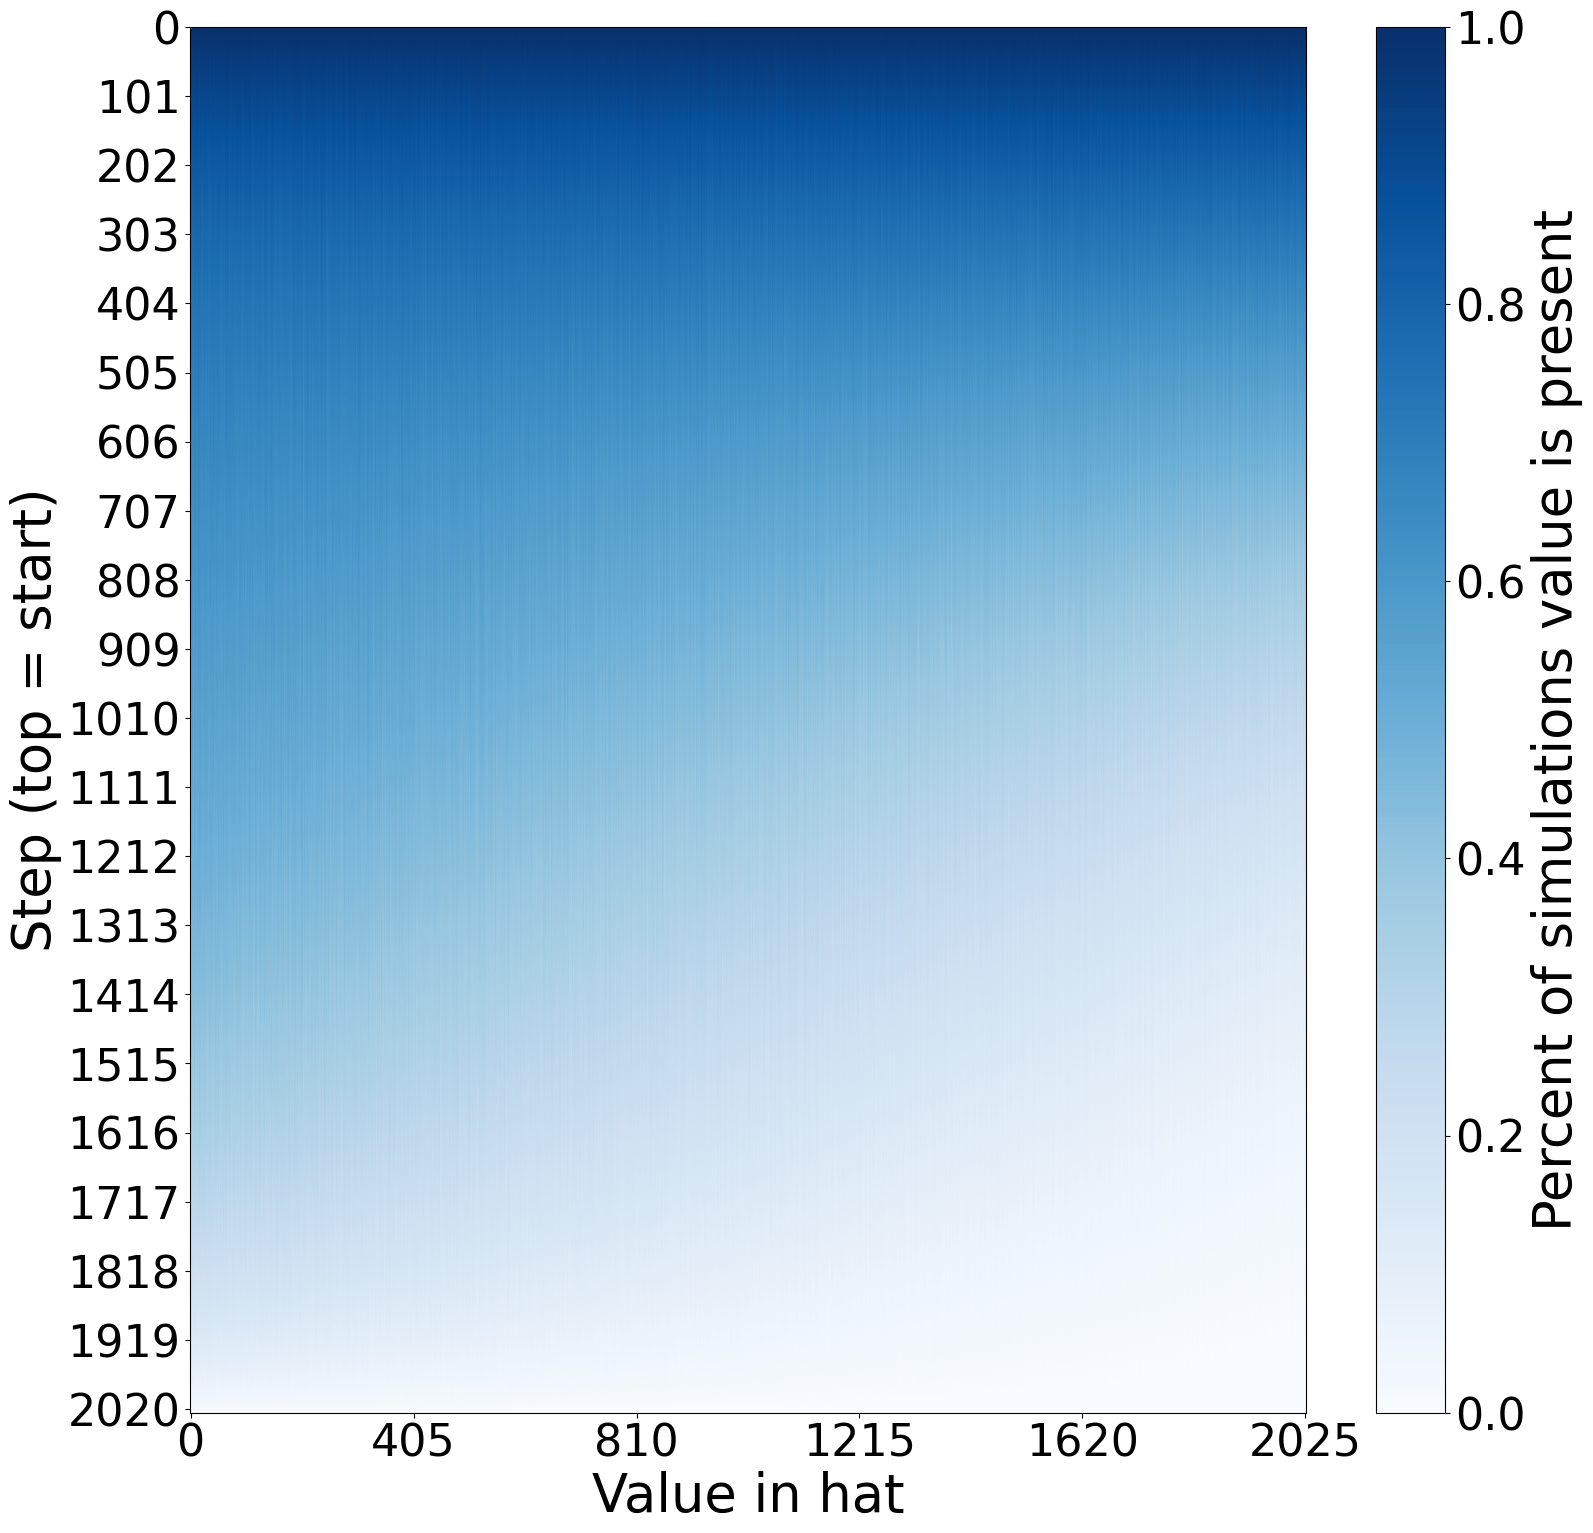

In [321]:
heathat(2026,5000)

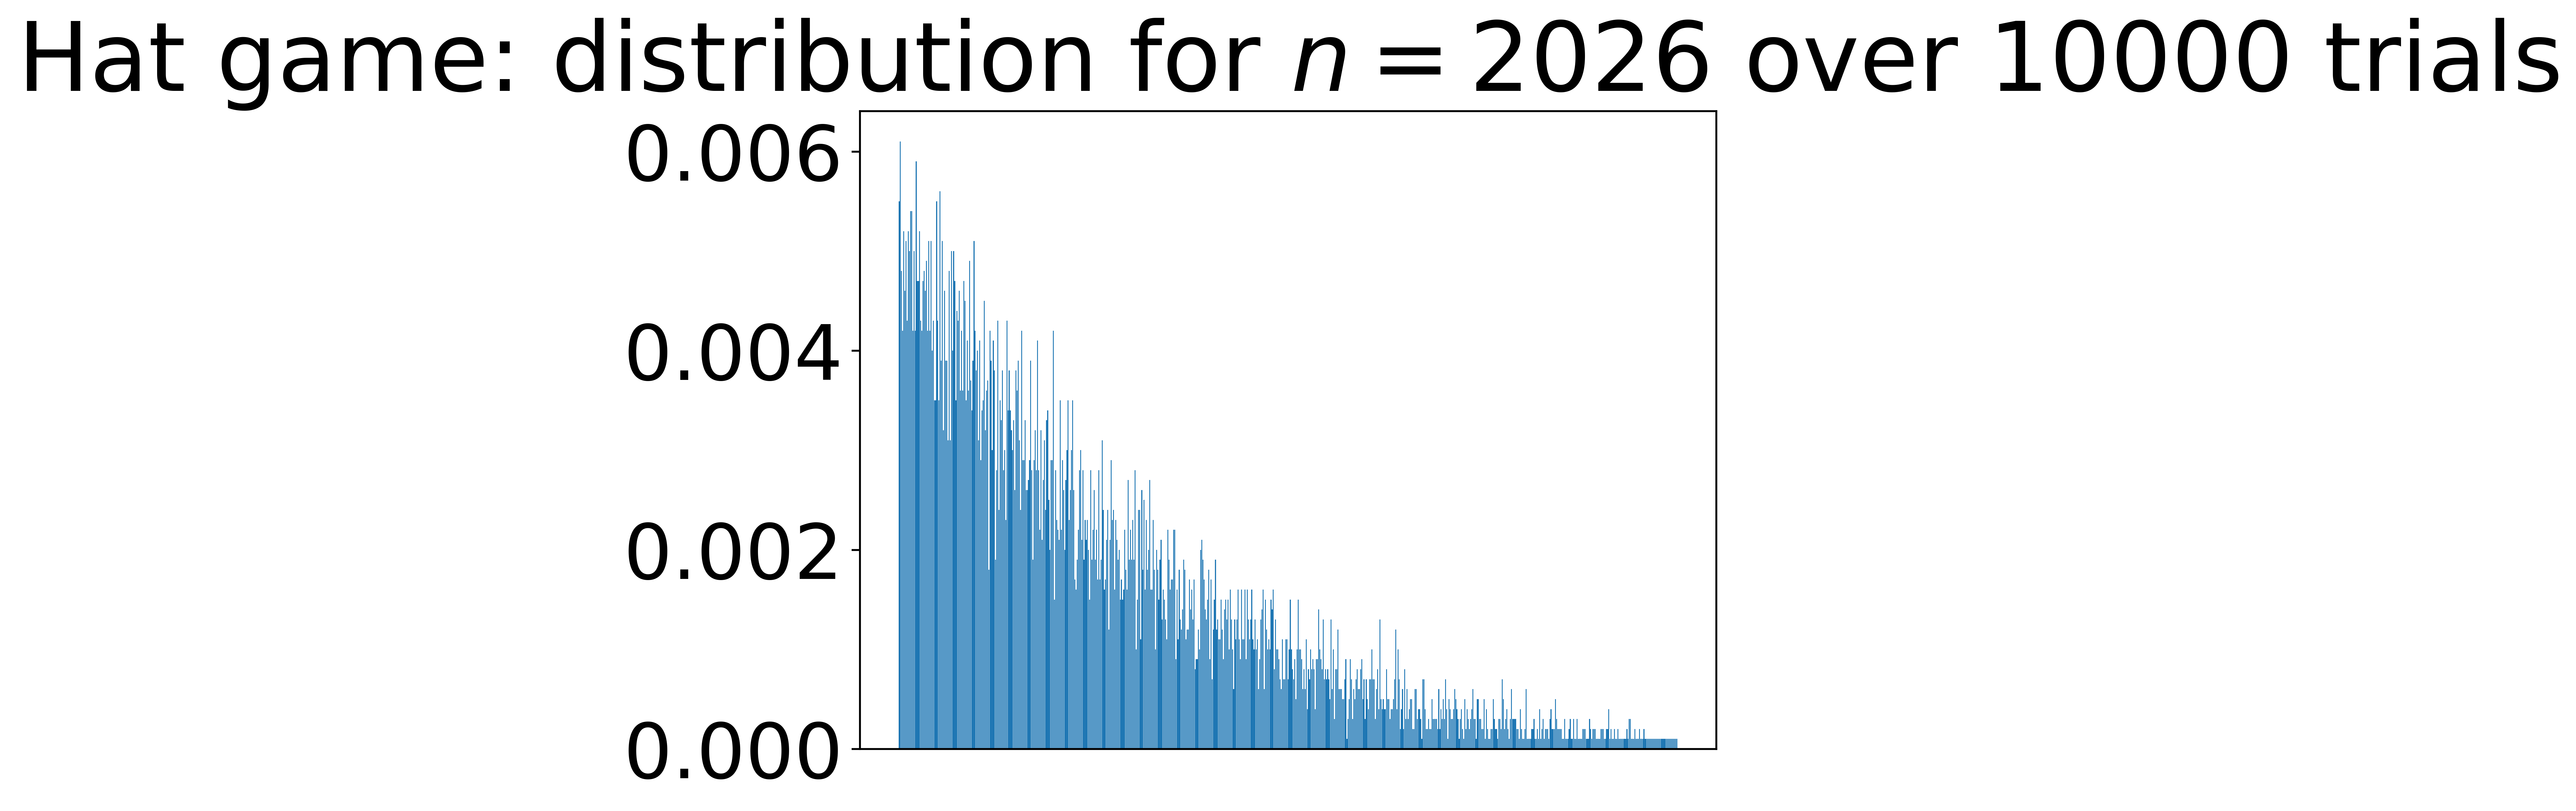

In [322]:
n = 2026
trials = 10000
counts = {}          

for _ in range(trials): 
    f = hat(n)
    counts[f] = counts.get(f, 0) + 1  

values = sorted(counts) 
probs = [counts[v] / trials for v in values]
max_prob = max(probs)

plt.figure(dpi=600)
plt.bar([str(v) for v in values], probs)

plt.xticks([])
plt.tick_params(axis='x', length=0)

plt.title(f"Hat game: distribution for $n={n}$ over ${trials}$ trials")
plt.ylim(0, 1.05 * max_prob) 
plt.show()

In [323]:
def hatsim(ns, trials):

    fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharex=False, sharey=False, dpi=600)

    for ax, n in zip(axes, ns):
        random.seed(0)  # makes hat(n) reproducible if it uses `random` internally

        vals = np.array([hat(n) for _ in range(trials)], dtype=int)

        counts = np.bincount(vals, minlength=n + 1)
        probs = counts / trials
        ks = np.arange(n + 1)

        ax.bar(ks, probs)
        ax.set_xlabel("Final value")
        ax.set_ylabel("Estimated probability")
        ax.set_title(f"N={n}")

        if n < 10:
        
            ax.set_xticks(ks)

        # separate y-scale per plot
        ymax = probs.max()
        ax.set_ylim(0, ymax * 1.10 if ymax > 0 else 1.0)
        
    plt.rcParams.update({
    "font.size": 14,   
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 14,
    })
    
    fig.tight_layout()
    fig.savefig(fname = 'hatmontecarlo',dpi=1800, bbox_inches="tight", pad_inches=0)
    plt.show()

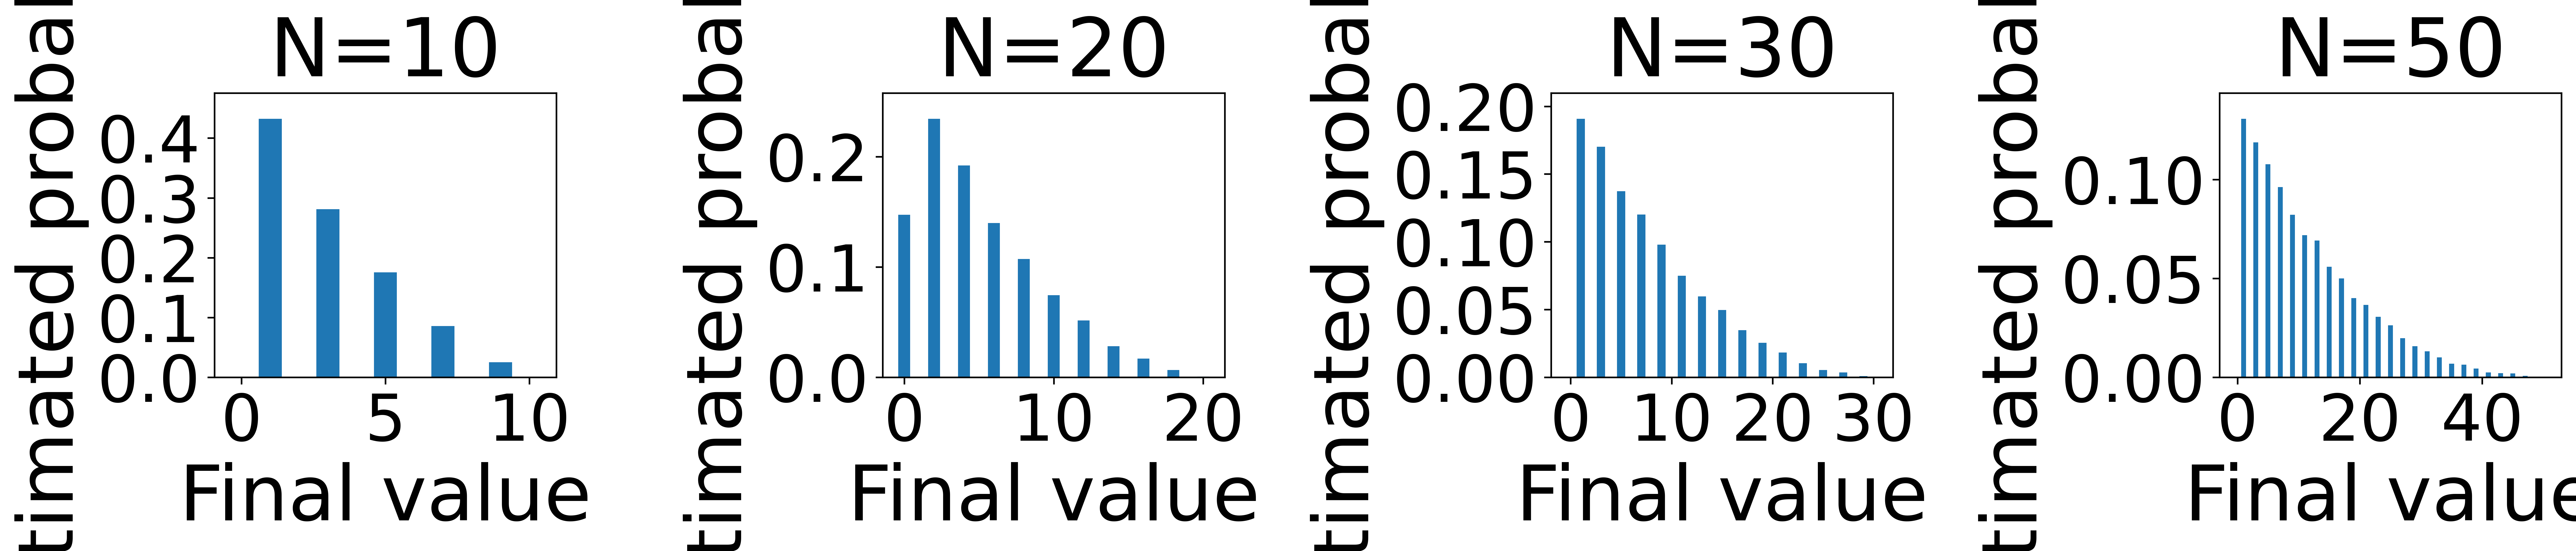

In [324]:
hatsim((10,20,30,50),10000)

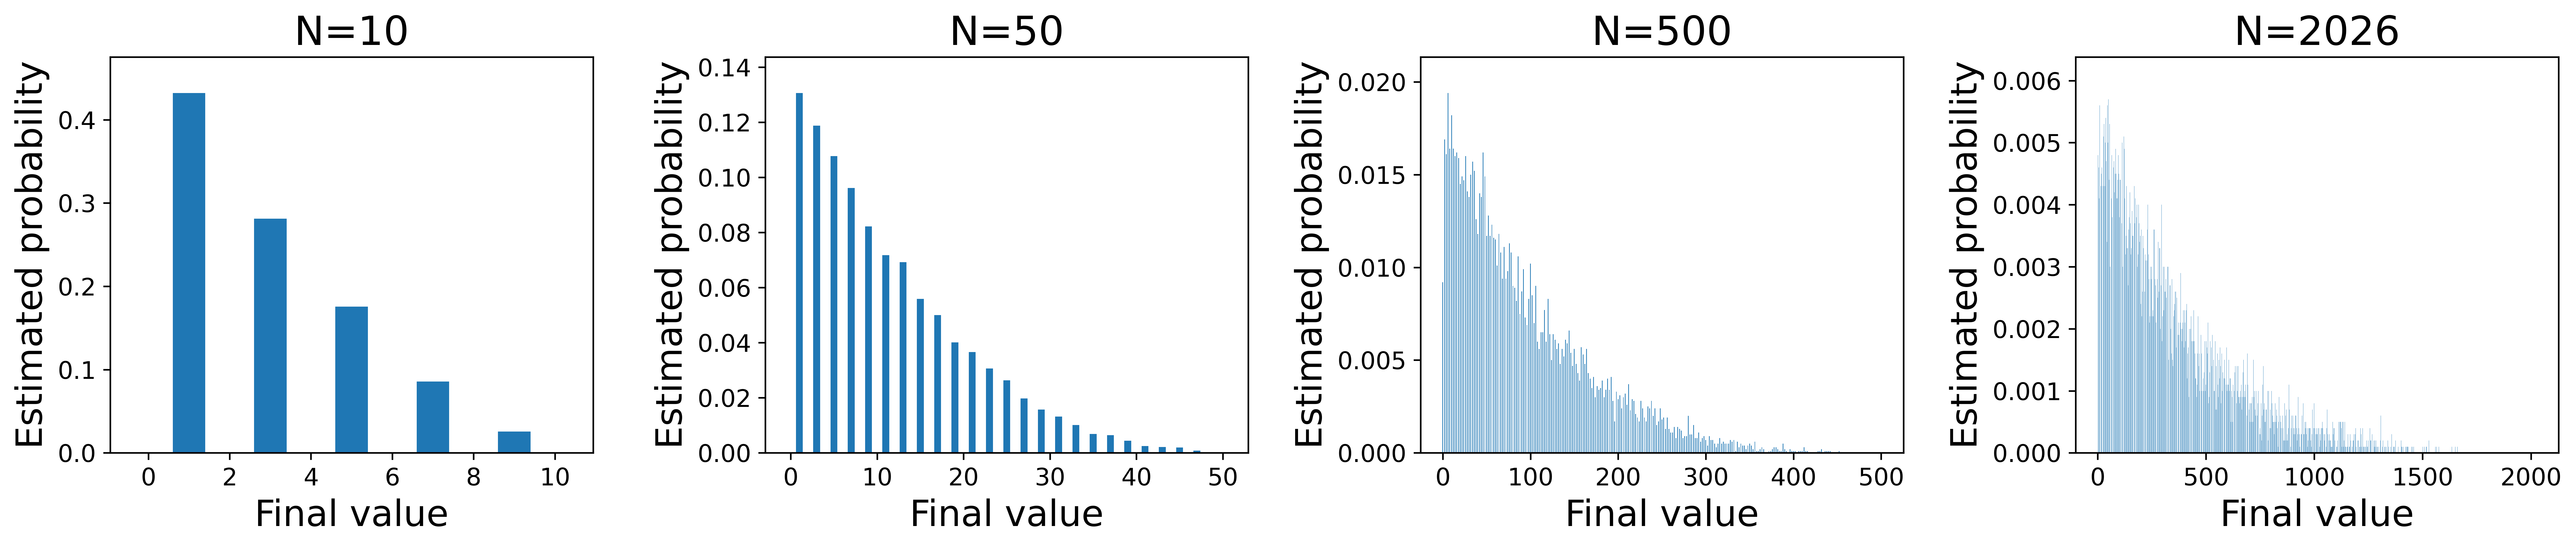

In [325]:
hatsim((10,50,500,2026),10000)

In [326]:
def hat_prob(n):

    #first make some helper functions

    def _gcd(a, b):
        a = abs(a); b = abs(b)
        while b:
            a, b = b, a % b
        return a

    def _reduce(num, den):
        if num == 0: return (0, 1)
        if den < 0: num, den = -num, -den
        g = _gcd(num, den)
        return (num // g, den // g)

    def _add_frac(x, y):
        n1, d1 = x; n2, d2 = y
        g = _gcd(d1, d2)
        s = n1 * (d2 // g) + n2 * (d1 // g)
        l = (d1 // g) * d2
        return _reduce(s, l)

    def _mul_frac(x, mul_num, mul_den):
        n1, d1 = x
        return _reduce(n1 * mul_num, d1 * mul_den)

    init = np.zeros(n + 1, dtype=np.int64)
    init[1:] = 1
    init_state = tuple(int(v) for v in init)

    cache: dict[tuple[int, ...], dict[int, tuple[int, int]]] = {}

    def solve(state: tuple[int, ...]) -> dict[int, tuple[int, int]]:
        if state in cache:
            return cache[state]

        m = sum(state)
        if m == 1:
            for v, c in enumerate(state):
                if c == 1:
                    out = {v: (1, 1)}
                    cache[state] = out
                    return out

        den = m * (m - 1)  # ordered picking without replacement
        present = [i for i, c in enumerate(state) if c]
        out: dict[int, tuple[int, int]] = {}

        for idx_a, a in enumerate(present):
            ca = state[a]

            # a==a
            if ca >= 2:
                mult = ca * (ca - 1)
                nxt = list(state)
                nxt[a] -= 2
                nxt[0] += 1
                sub = solve(tuple(nxt))
                for k, p in sub.items():
                    term = _mul_frac(p, mult, den)
                    out[k] = term if k not in out else _add_frac(out[k], term)

            # a<b
            for b in present[idx_a + 1:]:
                cb = state[b]
                mult = 2 * ca * cb
                d = b - a
                nxt = list(state)
                nxt[a] -= 1
                nxt[b] -= 1
                nxt[d] += 1
                sub = solve(tuple(nxt))
                for k, p in sub.items():
                    term = _mul_frac(p, mult, den)
                    out[k] = term if k not in out else _add_frac(out[k], term)

        cache[state] = out
        return out

    return solve(init_state)

In [327]:
print(hat_prob(11))

{6: (1161095741, 8840947500), 4: (3998500361, 17681895000), 8: (139256602, 2210236875), 2: (1494813401, 4420473750), 0: (492150178, 2210236875), 10: (110231771, 5893965000)}


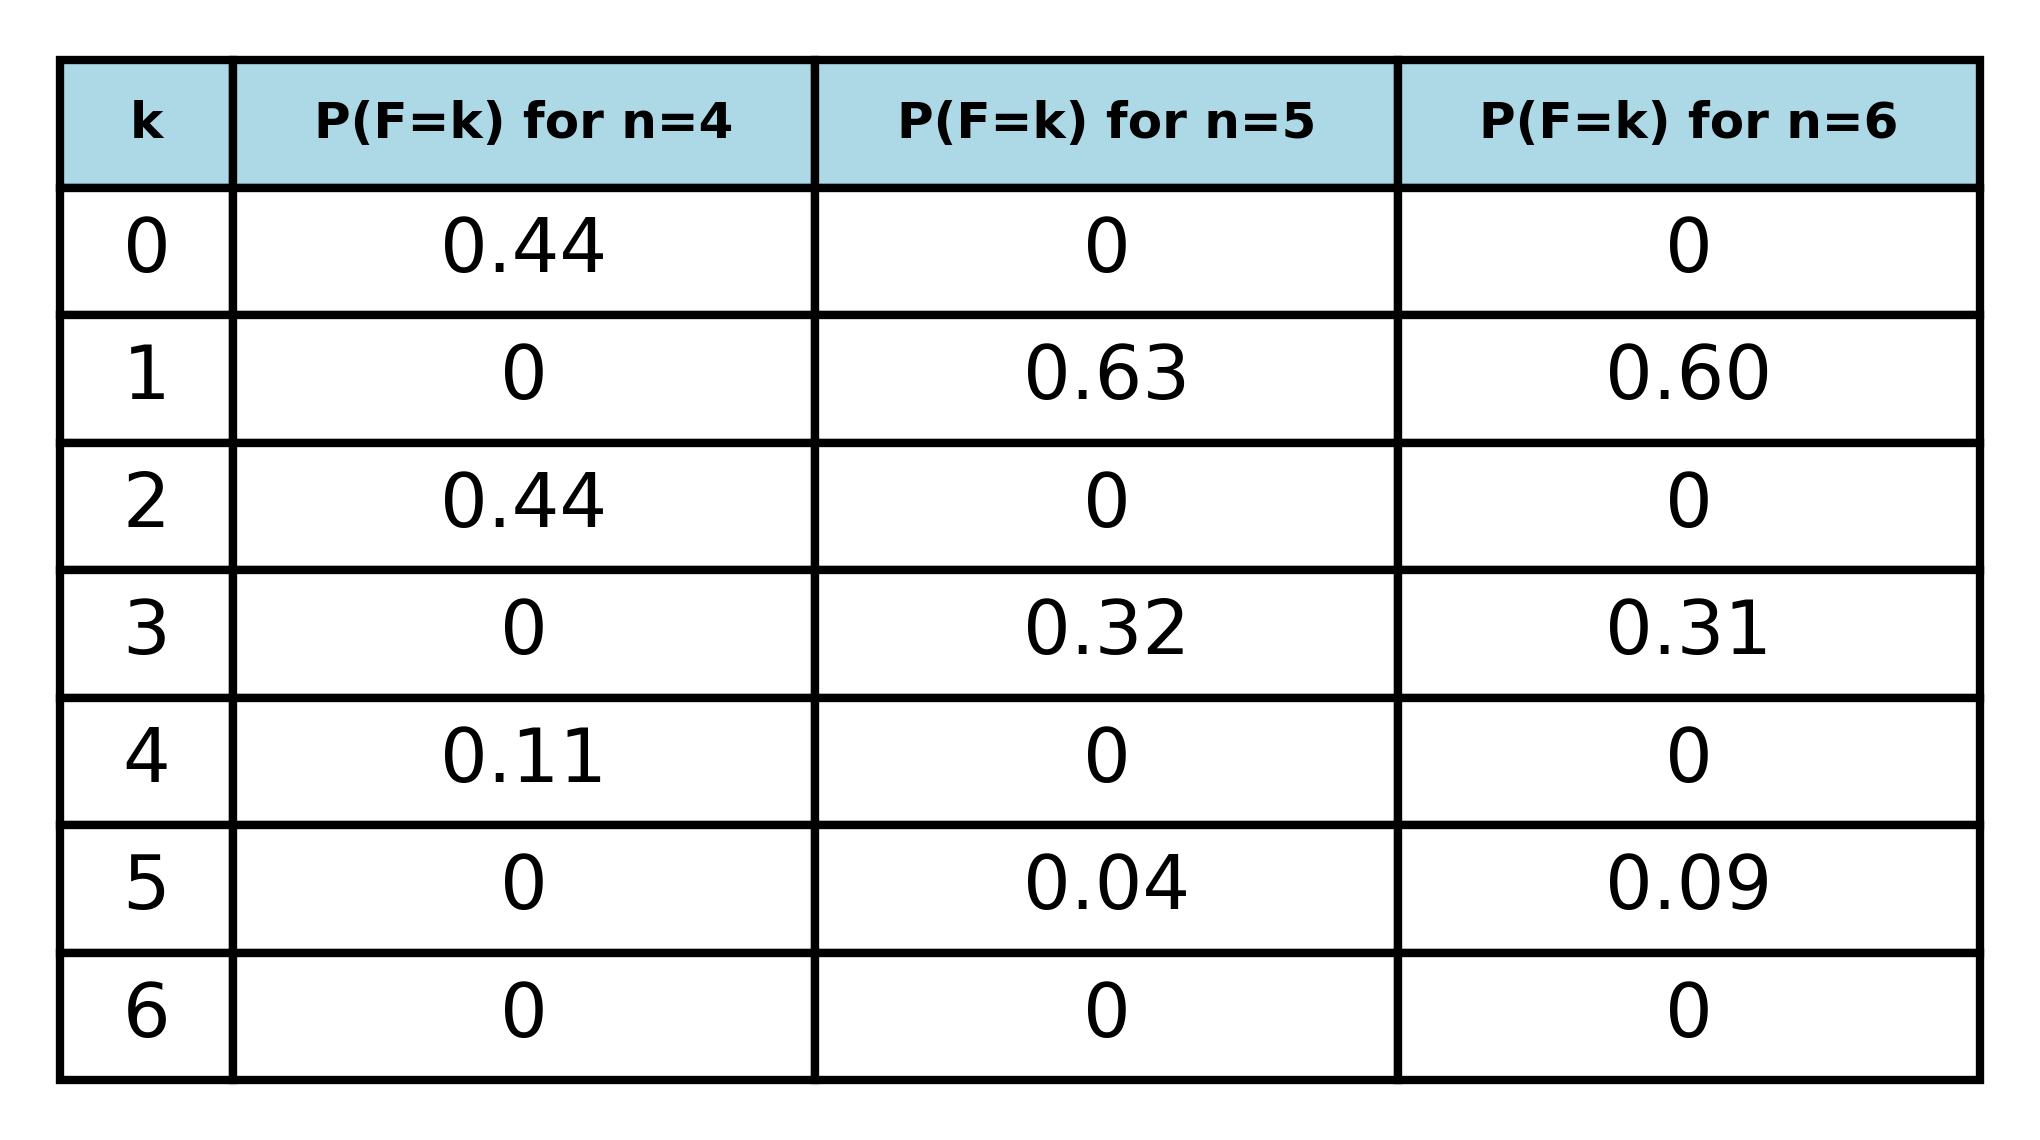

In [328]:
def _frac_str(fr):
    num, den = fr
    if num == 0:
        return "0"
    if den == 1:
        return str(num)
    return "{:.2f}".format(num/den)


def plot_prob_table_same(ns):

    nmax = max(ns)
    dists = {n: hat_prob(n) for n in ns}

    col_labels = ["k"] + [f"P(F=k) for n={n}" for n in ns]

    cell_text = []
    for k in range(nmax + 1):
        row = [str(k)]
        for n in ns:
            
            row.append(_frac_str(dists[n].get(k, (0, 1))))
        cell_text.append(row)

    ncols = 1 + len(ns)
    w0 = 0.09
    w_other = (1 - w0) / (ncols - 1)
    col_widths = [w0] + [w_other] * (ncols - 1)

    fig, ax = plt.subplots(figsize=(3.2, 1.7), dpi=600)
    ax.set_axis_off()
    ax.set_position([0, 0, 1, 1])
    fig.subplots_adjust(0, 0, 1, 1)

    tbl = ax.table(
        cellText=cell_text,
        colLabels=col_labels,
        colWidths=col_widths,
        cellLoc="center",
        colLoc="center",
        bbox=[0, 0, 1, 1]
    )

    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)

    for (r, c), cell in tbl.get_celld().items():
        cell.set_edgecolor("black")
        cell.set_linewidth(1.0)
        if r == 0: 
            cell.set_text_props(weight="bold")
            cell.set_fontsize(6)
            cell.set_facecolor("lightblue")

    fig.savefig(fname = "hat_table.png", dpi=600, bbox_inches="tight", pad_inches=0)
    plt.show()


plot_prob_table_same((4, 5, 6))

In [329]:
#for the extension all we nened to do is redefine the merge function!

def merge(nums):
    i, j = random.sample(range(len(nums)), 2) 
    a, b = nums[i], nums[j]  
    if i < j:                    
        del nums[j]
        del nums[i]
    else:
        del nums[i]
        del nums[j]

    nums.append(a - b)
    return nums

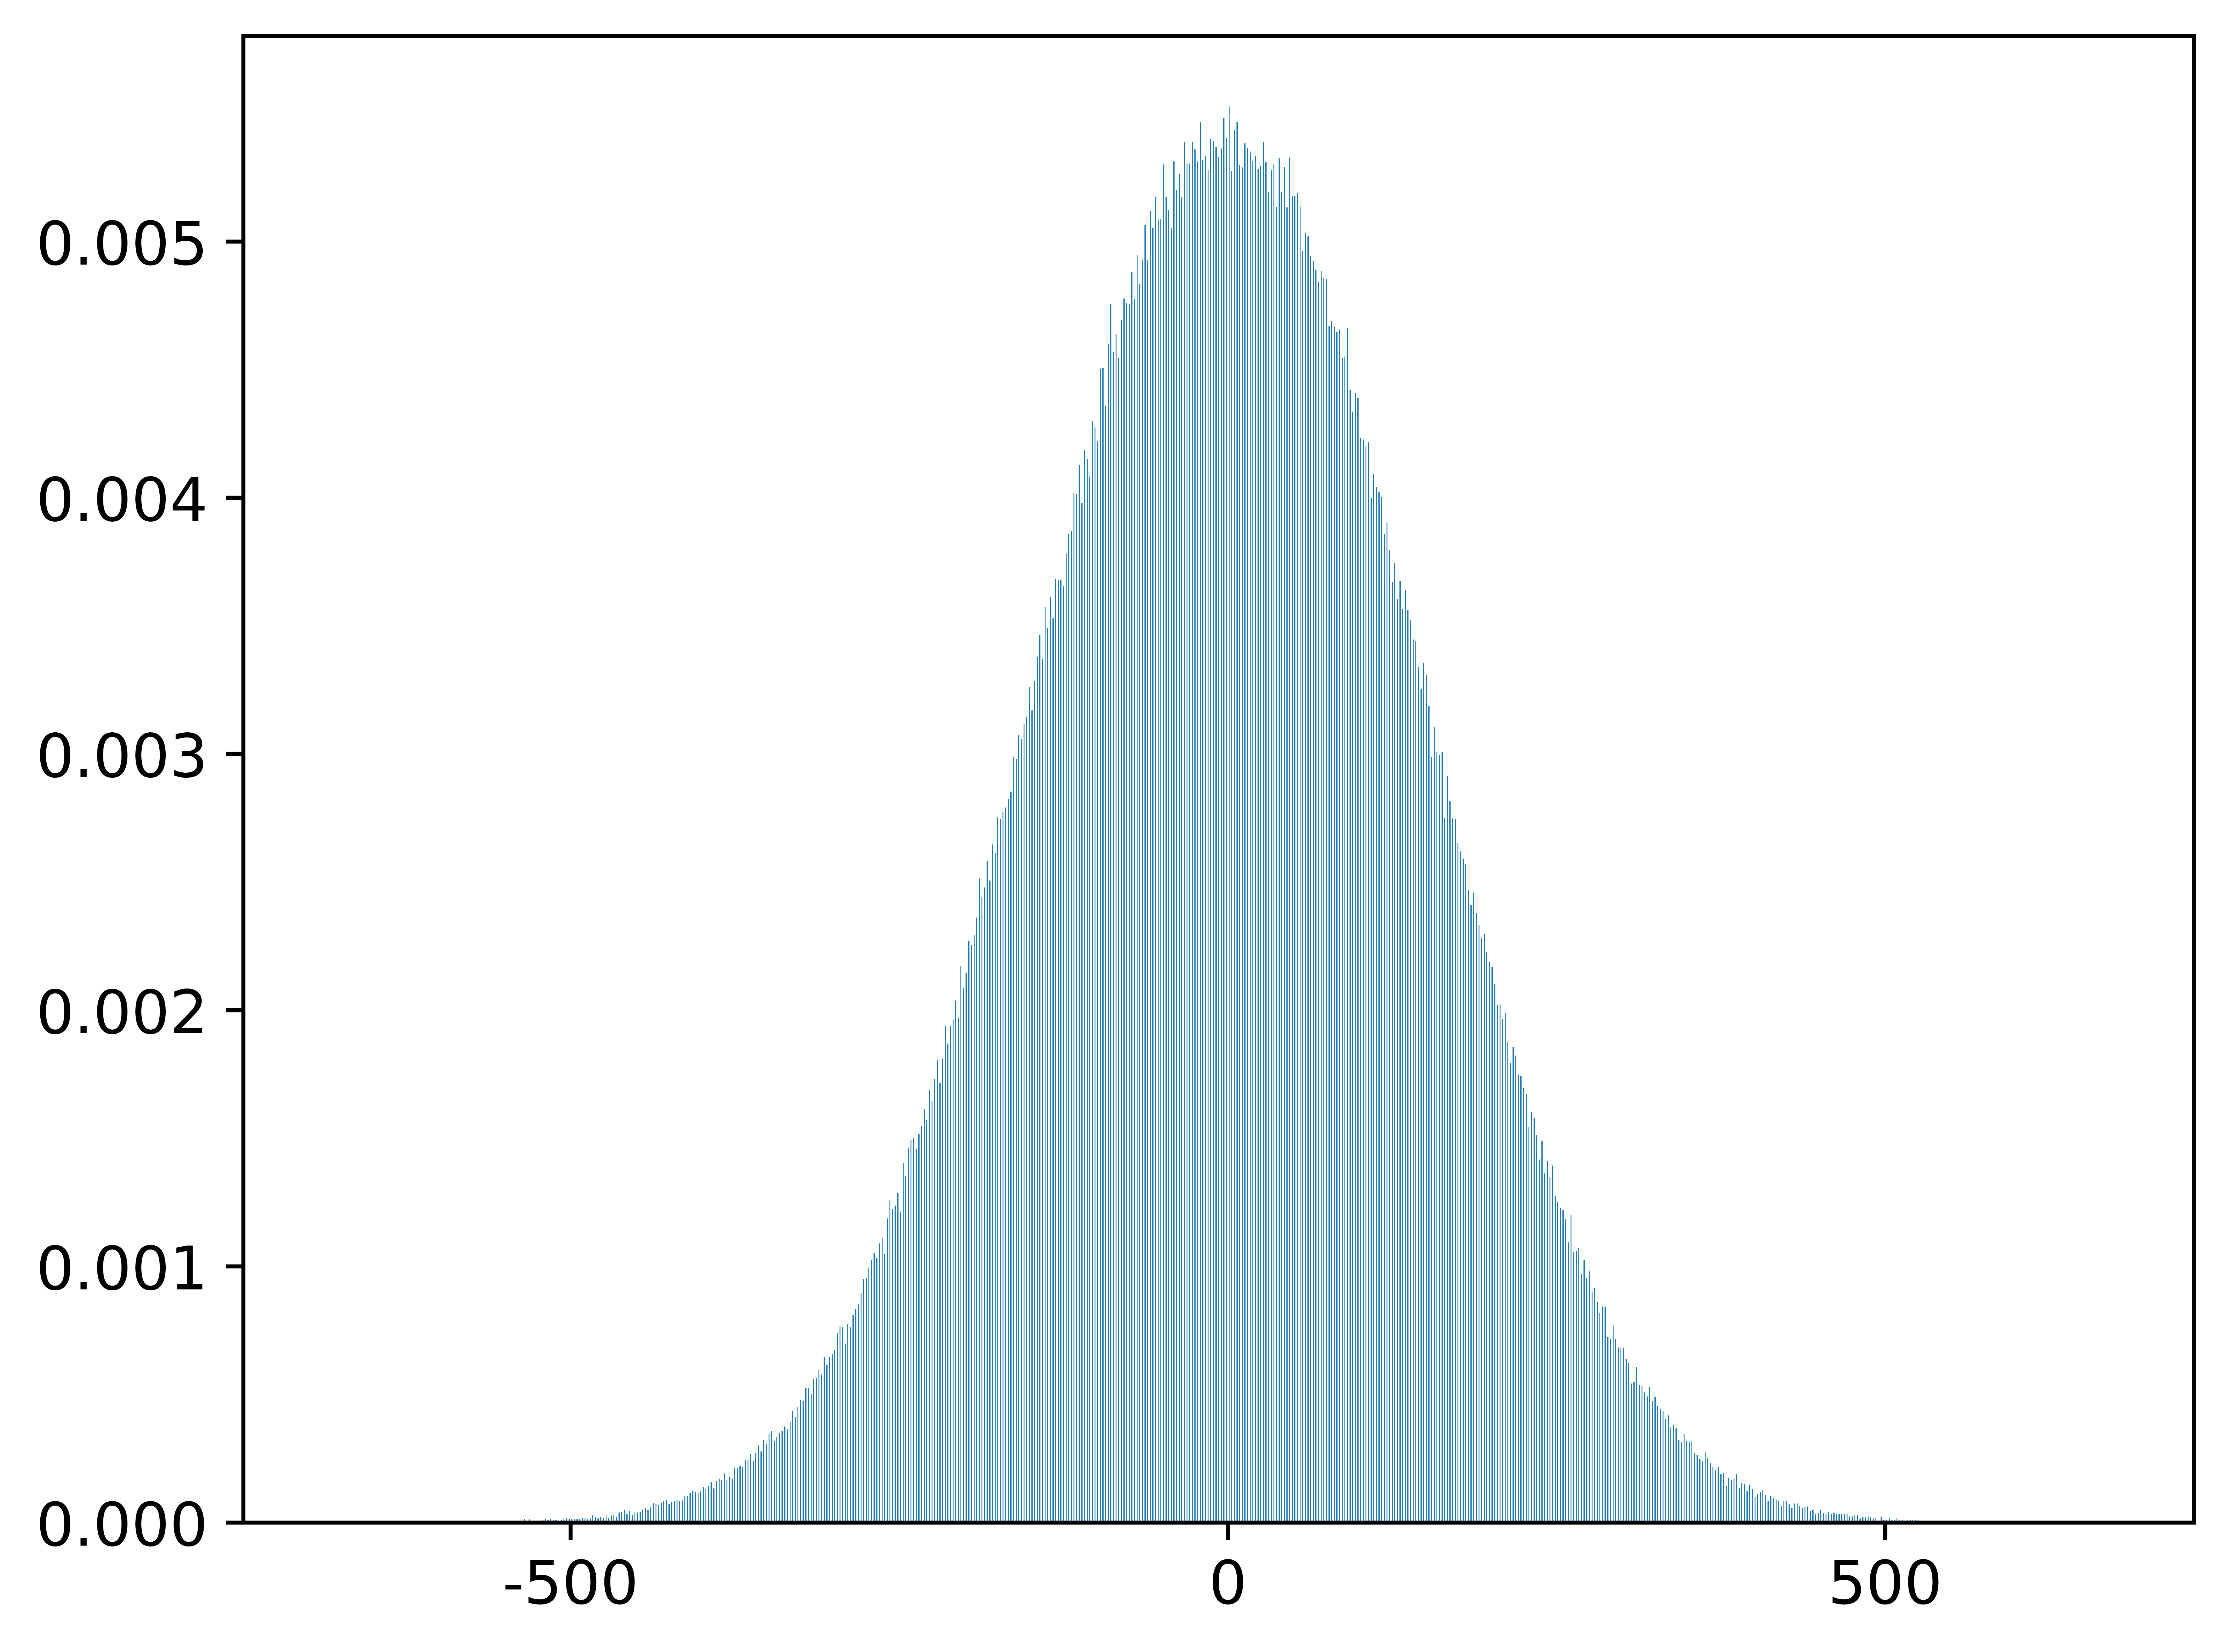

In [330]:
n = 50
trials = 1000000
counts = {}

for _ in range(trials):
    f = hat(n)
    counts[f] = counts.get(f, 0) + 1

values = np.array(sorted(counts.keys()), dtype=int)
probs  = np.array([counts[v] / trials for v in values], dtype=float)
max_prob = probs.max()

plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
})

fig = plt.figure(dpi=1200)
plt.bar(values, probs, width=0.8) 

plt.xticks([-10*n, 0, 10*n], [str(-n*10), "0", str(n*10)])

plt.ylim(0, 1.05 * max_prob)
plt.tight_layout()
fig.savefig(fname = 'extension.png', dpi=600, bbox_inches="tight", pad_inches=0)
plt.show()